# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [3]:
df = pd.read_csv('data/finance_datasets/currency_exchange/final_dataset.csv')
cols = list(df)[3:]
cols[0], cols[1] = cols[1], cols[0]
cols

['EUR/USD',
 'CAD/USD',
 'JPY/USD',
 'GBP/USD',
 'CHF/USD',
 'AUD/USD',
 'HKD/USD',
 'NZD/USD',
 'KRW/USD',
 'MXN/USD']

In [4]:
data = []
for c in cols:
    data.append(mogptk.LoadCSV('data/finance_datasets/currency_exchange/final_dataset.csv',
                               x_cols='Day',
                               y_col=c,
                               name=c))
for d in data:
    d.transform(mogptk.TransformDetrend)

## Create and fit model

Remove data to simulate sensor failure

In [5]:
# randomly sample from the data
for channel in data:
    channel.remove_randomly(pct=0.3)

# drop chunks to simulate sensor failure

data[0].remove_range(df['Day'].iloc[-1], None)
data[1].remove_range(90, 120)
data[2].remove_range(480, 520)
data[3].remove_range(200, 250)
data[4].remove_range(None, 30)
data[5].remove_range(None, 30)
data[7].remove_range(500, 550)

for i in range(1, len(cols)):
     data[i].remove_range(650, None)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

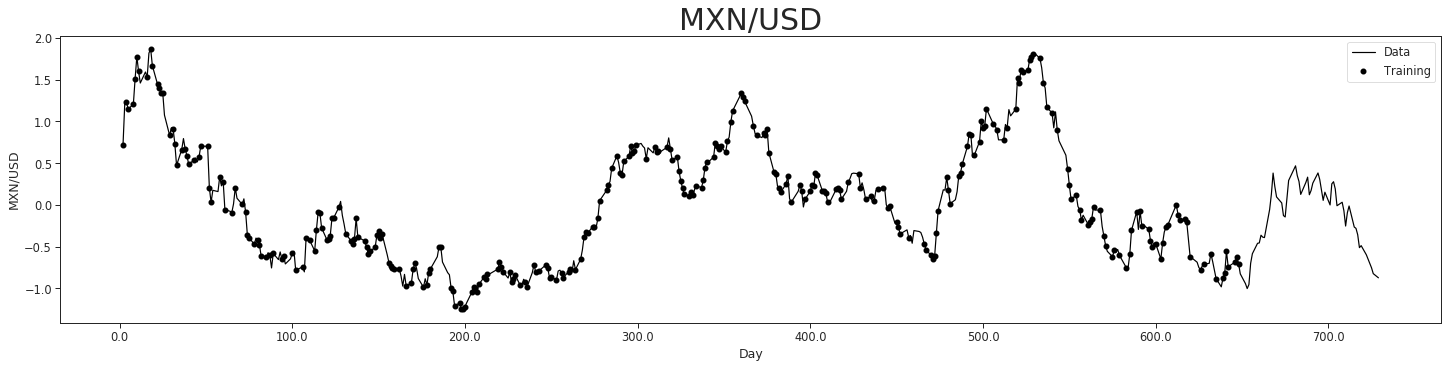

In [6]:
i = 9
data[i].plot()

## MOSM

warning!!!, long time of execution

In [ ]:
%%time
n_trials = 1

mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=5)
    model_mosm.init_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    print('Finished trial', n)
    print('='*50)        
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
cols = [c.split('/')[0] for c in cols]

In [ ]:
best_model = mosm_list[np.argmin(mosm_mape.mean(1))]
ylims = [(0.77, 1), (1.19, 1.45),
         (104, 120), (0.68, 0.87),
         (0.9, 1.06), (1.2, 1.5),
         (7.74, 7.9), (1.3, 1.63),
         (1050, 1210), (17, 23)]
f, axarr = mogptk.plot_prediction(model_mosm,
                       grid=(5, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 8));

yticks = [(0.8, 0.95), (1.2, 1.4),
          (105, 117), (0.69, 0.85),
          (0.93, 1.03), (1.25, 1.45),
          (7.75, 7.85), (1.32, 1.58),
          (1070, 1200), (18, 22)]

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=13)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = model_mosm.data[i]

    # xlabels = pd.date_range(df['Unnamed: 0'].iloc[0], df['Unnamed: 0'].iloc[-1], periods=9).date
    # xticks = [formatter._parse(str(label)) for label in xlabels]
    
    xlabels = pd.date_range('2017-01-01', '2019-01-01', periods=5)
    xticks = (xlabels - np.datetime64('2017-01-01')).days.values
    
    
    new_xlabels = xlabels.date
    new_xlabels[1::2] = ['']*2
    # xlabels[::2][2:] += datetime.timedelta(days=1)
    # new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    axarr[i].set_xticklabels(new_xlabels)

plt.tight_layout()
# plt.savefig('output/mosm_exchange_rate.pdf', bbox_inches='tight')

In [ ]:
f, ax, corr_matrix = model_mosm.plot_correlations(9)
ax.set_title('Exchange rate', pad=20)
ax.set_yticks(np.arange(10));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(10));
ax.set_xticklabels(cols);
plt.tight_layout()
# plt.savefig('output/corr_exchange.pdf', bbox_inches='tight')

## CSM

In [ ]:
n_trials = 1

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=5)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
mogptk.plot_prediction(model_csm, grid=(5, 2), names=cols, title='Exchange prices CSM');

## SM-LMC

In [ ]:
n_trials = 1

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=5)
    model_smlmc.init_params('BNSE')
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
mogptk.plot_prediction(model_smlmc, grid=(5, 2), names=cols, title='Exchange prices SM-LMC');

## Compare All

In [ ]:
print(mosm_mae[:, 1:].mean(), csm_mae[:, 1:].mean(), smlmc_mae[:, 1:].mean())

In [ ]:
print(mosm_mape[:, 1:].mean(), csm_mape[:, 1:].mean(), smlmc_mape[:, 1:].mean())

In [ ]:
print(mosm_rmse[:, 1:].mean(), csm_rmse[:, 1:].mean(), smlmc_rmse[:, 1:].mean())

In [ ]:
f, ax, corr_matrix = model_mosm.plot_correlations()
ax.set_title('Currency exchange Cross correlation matrix', pad=20)
ax.set_yticks(np.arange(10));
ax.set_xticks(np.arange(10));
plt.savefig('output/corr_currency.pdf', bbox_inches='tight')

In [ ]:
f, axarr = model_mosm.plot_psd()

## IGP
Independant gaussian process with spectral mixture kernel

Q = 4

x_pred = {i:array for i, array in enumerate(data.X_all)}

igp_mae = np.zeros((n_trials, len(cols)))
igp_mape = np.zeros((n_trials, len(cols)))
igp_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):    

    for i in range(len(cols)):
        # create data
        data_single = mogptk.Data()
        data_single.add(data.X[i], data.Y[i])
        
        model = mogptk.SM(data_single, Q=Q)
        model.init_params('BNSE')
        model.train(method='L-BFGS-B', maxiter=3000, tol=1e-15)
        
        idx = data.Y_all[i] != 0
        
        y_pred, var_pred = model.predict(x_pred)
        
        igp_mae[n, i] = np.abs(data.Y_all[i] - y_pred[0]).mean() # MAE
        igp_mape[n, i] = np.abs((data.Y_all[i][idx] - y_pred[0][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
        igp_mse[n, i] = ((data.Y_all[i] - y_pred[0])**2).mean() # MSE